In [1]:
!pip install openeo
!pip install rasterio
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.4/283.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 30.6 MB/s eta 0:00:00


In [2]:
import scipy
import numpy as np
import openeo
from openeo.extra.spectral_indices import compute_indices
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import rasterio
from rasterio.plot import show
from ipyleaflet import Map, DrawControl, TileLayer
from ipywidgets import Layout
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [3]:


# your_library/api_connection.py


def connect_to_openeo():
    """
    Establish a connection to the OpenEO API and authenticate.

    Returns:
        openeo.Connection: An authenticated connection object.
    """
    try:
        # Connect to the OpenEO API and authenticate using OIDC
        connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
        print("Successfully connected and authenticated with OpenEO.")
        return connection
    except Exception as e:
        print(f"Failed to connect to OpenEO: {e}")
        raise





In [4]:
#load map function

def load_map():
  # Define the map center (latitude, longitude)
  center_location = [45.4642, 9.1900]  # Example: Milan, Italy

# Create a map object with a specified layout
  m = Map(center=center_location, zoom=5, layout=Layout(height="600px"))

# Add OpenStreetMap (OSM) as the basemap
  osm_layer = TileLayer(url="https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png", name="OpenStreetMap")
  m.add_layer(osm_layer)

# Add a DrawControl to enable drawing shapes
  draw_control = DrawControl()

# Customize the drawing options (enable rectangle only)
  draw_control.rectangle = {
    "shapeOptions": {
        "color": "#3388ff",
        "fillColor": "#3388ff",
        "fillOpacity": 0.5,
    }
  }

# Disable other shapes by passing empty dictionaries
  draw_control.circle = {}
  draw_control.circlemarker = {}
  draw_control.polygon = {}
  draw_control.polyline = {}
  draw_control.marker = {}

# Global variable for extent
  extent = {}

# Function to handle rectangle drawing
  def handle_draw(self, action, geo_json):
      global extent  # Declare that we're using the global variable

    # Check if the event contains a polygon (rectangle)
      if geo_json['geometry']['type'] == 'Polygon':
          coordinates = geo_json['geometry']['coordinates'][0]  # Extract the list of coordinates

        # Calculate the bounding box
          west = min([coord[0] for coord in coordinates])
          south = min([coord[1] for coord in coordinates])
          east = max([coord[0] for coord in coordinates])
          north = max([coord[1] for coord in coordinates])

        # Update the global extent variable
          extent = {"west": west, "south": south, "east": east, "north": north}
          print(f"Rectangle Extent: {extent}")

# Attach the drawing handler to the control
  draw_control.on_draw(handle_draw)
# Add the draw control to the map
  m.add_control(draw_control)

  m

# Display the map
  return m

# Now you can access the 'extent' variable later in your code
# For example, in another block you can access it like this:
# print(extent)  # This will print the extent in the format you defined


In [5]:
def getBAP(scl, data, reducer="first"):
    mask = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10)

    # mask is a bit noisy, so we apply smoothening
    # 2D gaussian kernel
    g = scipy.signal.windows.gaussian(11, std=1.6)
    kernel = np.outer(g, g)
    kernel = kernel / kernel.sum()

    # Morphological dilation of mask: convolution + threshold
    mask = mask.apply_kernel(kernel)
    mask = mask > 0.1

    data_masked = data.mask(mask)

    # now select Best Available Pixel based on the mask
    return data_masked.reduce_dimension(reducer=reducer, dimension="t")

In [6]:
def get_date_input(prompt):
    while True:
        user_input = input(prompt)
        try:
            # Try to parse the date using the format
            date = datetime.strptime(user_input, "%Y-%m-%d")
            return date
        except ValueError:
            # If the date is not in the correct format, show an error message
            print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

In [7]:
def get_start_and_end_dates():
    start_date = get_date_input("Enter the start date (YYYY-MM-DD): ")
    end_date = get_date_input("Enter the end date (YYYY-MM-DD): ")

    # Check if the start date is before the end date
    if start_date > end_date:
        print("Start date cannot be after end date. Please try again.")
        return get_start_and_end_dates()  # Recursively ask for dates again
    else:
        return start_date, end_date

In [8]:
def load_pre_ndvi(connection, extent, start_date, end_date):
  # load S2 pre-collection
  s2pre = connection.load_collection(
      "SENTINEL2_L2A",
      temporal_extent=["2022-04-01", "2022-08-30"],
      spatial_extent=extent,
      bands=["B03","B04", "B08", "B12"],
      max_cloud_cover=10,
  )

# Reduce the collection to a max composite
  s2pre_max = s2pre.reduce_dimension(dimension="t", reducer="max")
# calculate ndvi
  ndvi_pre = s2pre_max.ndvi()
  ndvi_pre.download("NDVI_PRE.tiff")


In [9]:
def plot_pre_ndvi():
  b = rasterio.open("NDVI_PRE.tiff")
# Create a figure and axis
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(18, 6))
  im = show(b.read(1),vmin=0, vmax=1,transform=b.transform,ax=ax,cmap='Reds')
# Add a colorbar
  cbar = plt.colorbar(im.get_images()[0], ax=ax, orientation='vertical')
  cbar.set_label('NDVI Value')
# Set title
  ax.set_title("Pre Event NDVI")
# Show the plot
  plt.show()

In [10]:
def load_post_ndvi(connection, extent, start_date, end_date):
  # load S2 post collection
  final_date = end_date + relativedelta(months=+2)
  s2post = connection.load_collection(
      "SENTINEL2_L2A",
      temporal_extent=[start_date, final_date],
      spatial_extent=extent,
      bands=["B04", "B08", "B12"],
      max_cloud_cover=10,
  )
  # calculate ndvi
  ndvi_post = s2post.ndvi()
  # download NDVI for post-event mode for comparison
  ndvi_post.download("Post_NDVI.tiff")

In [11]:
def plot_post_ndvi():
  b = rasterio.open("Post_NDVI.tiff")
  # Create a figure and axis
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(18, 6))
  im = show(b.read(1),vmin=0, vmax=1,transform=b.transform,ax=ax,cmap='Reds')
  # Add a colorbar
  cbar = plt.colorbar(im.get_images()[0], ax=ax, orientation='vertical')
  cbar.set_label('NDVI Value')
  # Set title
  ax.set_title("Post Event NDVI")
  # Show the plot
  plt.show()

In [12]:
def fire_detector_ndvi():
  # Open the pre-fire and post-fire NDVI raster files
  with rasterio.open("NDVI_PRE.tiff") as src_pre, rasterio.open("Post_NDVI.tiff") as src_post:
      # Read the data as numpy arrays (assuming single band)
      ndvi_pre = src_pre.read(1)
      ndvi_post = src_post.read(1)

      # Calculate the difference (Pre - Post)
      final_fire_NDVI = ndvi_post - ndvi_pre

      # Plot the resulting final_fire_NDVI
      f, ax = plt.subplots(1, 1, dpi=100, figsize=(18, 6))
      im = ax.imshow(final_fire_NDVI, vmin=-1, vmax=1, cmap='Greens')  # Adjust vmin and vmax as needed

      # Add a colorbar
      cbar = plt.colorbar(im, ax=ax, orientation='vertical')
      cbar.set_label('NDVI Value')

      # Set title
      ax.set_title("Fire Area - NDVI Difference")

      # Show the plot
      plt.show()


In [31]:
def load_pre_nbr(connection, extent, start_date, end_date):
  # Load Sentinel-2 pre-collection
  s2pre = connection.load_collection(
      "SENTINEL2_L2A",
      temporal_extent=["2022-04-01", "2022-08-30"],
      spatial_extent=extent,
      bands=["B03","B04","B08","B12"],
      max_cloud_cover=10,
  )

  # Reduce the collection to a max composite
  s2pre_max = s2pre.reduce_dimension(dimension="t", reducer="max")

  # Calculate NDVI
  ndvi_pre = s2pre_max.ndvi()

  # Calculate NDWI (Normalized Difference Water Index)
  green = s2pre_max.band("B03")  # Green band
  nir = s2pre_max.band("B08")  # Near Infrared (NIR) band
  ndwi = (green - nir) / (green + nir)  # NDWI formula: (Green - NIR) / (Green + NIR)

  # Apply a threshold to detect water areas (NDWI > 0.2 indicates water)
  threshold = 0.0
  water_mask = ndwi > threshold  # Mask for water areas where NDWI > 0.2

  ######################## Mask NDVI: Remove areas where NDWI is greater than the threshold (i.e., water)
  #######################ndvi_pr = ndvi_pre.mask(~water_mask)  # Mask out water areas from NDVI (invert the water mask)



  # Calculate NBR (Normalized Burn Ratio)
  NIR  = s2pre_max.band("B08")  # Near-Infrared
  SWIR  = s2pre_max.band("B12")  # Short-Wave Infrared
  NBR_Pre = (NIR - SWIR) / (NIR + SWIR)  # NBR formula: (NIR - SWIR) / (NIR + SWIR)

  NBR_Pre.download("NBR_PRE.tiff")
  ndwi.download("NDWI.tiff")

In [29]:
def post_nbr(connection, extent, start_date, end_date):
  # load S2 post collection
  final_date = end_date + relativedelta(months=+2)
  s2post = connection.load_collection(
      "SENTINEL2_L2A",
      temporal_extent=[start_date, final_date],
      spatial_extent=extent,
      bands=["B03","B04","B08","B12"],
      max_cloud_cover=10,
  )
  # calculate ndvi
  ndvi_post = s2post.ndvi()

  # Calculate NBR (Normalized Burn Ratio)
  NIR  = s2post.band("B08")  # Near-Infrared
  SWIR  = s2post.band("B12")  # Short-Wave Infrared
  NBR_Post = (NIR - SWIR) / (NIR + SWIR)  # NBR formula: (NIR - SWIR) / (NIR + SWIR)
  NBR_Post.download("NBR_Post.tiff")

In [14]:
def plot_nbr():
  b = rasterio.open("NBR_Post.tiff")
  # Create a figure and axis
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(18, 6))
  im = show(b.read(1),vmin=0, vmax=1,transform=b.transform,ax=ax,cmap='Reds')
  # Add a colorbar
  cbar = plt.colorbar(im.get_images()[0], ax=ax, orientation='vertical')
  cbar.set_label('NBR Value')
  # Set title
  ax.set_title("Post Event NBR")
  # Show the plot
  plt.show()

In [15]:
def fire_detector_nbr():
  # Open the pre-fire and post-fire NBR raster files
  with rasterio.open("NBR_PRE.tiff") as src_pre, rasterio.open("NBR_Post.tiff") as src_post:
      # Read the data as numpy arrays (assuming single band)
      NBR_Pre = src_pre.read(1)
      NBR_Post = src_post.read(1)

      # Calculate the difference (Post - Pre)
      final_fire_NBR = NBR_Pre - NBR_Post

      # Plot the resulting final_fire_NBR
      f, ax = plt.subplots(1, 1, dpi=100, figsize=(18, 6))
      im = ax.imshow(final_fire_NBR, vmin=-1, vmax=1, cmap='Reds')  # Adjust vmin and vmax as needed

      # Add a colorbar
      cbar = plt.colorbar(im, ax=ax, orientation='vertical')
      cbar.set_label('NBR Value')

      # Set title
      ax.set_title("Fire Area - NBR Difference")

      # Show the plot
      plt.show()

In [16]:
def fire_area_nbr():
  # Define parameters for the median filter
  kernel_size = 3  # Size of the neighborhood (adjust as needed)
  iterations = 1  # Number of times to apply the filter (adjust as needed)

  # Open the pre-fire and post-fire NBR raster files and the NDWI raster
  with rasterio.open("NBR_PRE.tiff") as src_pre, rasterio.open("NBR_Post.tiff") as src_post, rasterio.open("NDWI.tiff") as src_ndwi:
      # Read the data as numpy arrays (assuming single band)
      NBR_Pre = src_pre.read(1)
      NBR_Post = src_post.read(1)
      NDWI = src_ndwi.read(1)

      # Calculate the difference (Post - Pre)
      final_fire_NBR = NBR_Pre - NBR_Post

  # Apply the condition: fire areas based on NBR > 0.25 and exclude water areas where NDWI > 0
  fire_condition = (final_fire_NBR > 0.25) & (NDWI <= 0)

  # Apply median filter to remove salt-and-pepper noise, with specified kernel size and iterations
  filtered_fire_condition = fire_condition
  for _ in range(iterations):
      filtered_fire_condition = median_filter(filtered_fire_condition, size=kernel_size)

  # Define the colormap and labels
  cmap = matplotlib.colors.ListedColormap(["black", "firebrick"])
  values = ["Absence", "Presence"]
  colors = ["black", "firebrick"]

  # Plot the results
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(12, 6))  # Change axarr to ax

  im = show(
      filtered_fire_condition,  # Use the filtered fire condition after applying the median filter
      vmin=0,
      vmax=1,
      transform=src_pre.transform,  # Use the transform from the original raster
      ax=ax,  # Use ax directly instead of axarr[0]
      cmap=cmap,
  )

  ax.set_title("Fire Area With NBR Mode")  # Use ax directly instead of axarr[0]

  # Create legend
  patches = [
      mpatches.Patch(color=colors[i], label="Fire {l}".format(l=values[i]))
      for i in range(len(values))
  ]
  f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)
  plt.tight_layout()
  plt.show()


In [17]:
def fire_area_ndvi():
  # Define parameters for the median filter
  kernel_size = 3  # Size of the kernel (larger value = stronger filtering)
  iterations = 1  # Number of iterations (for further refinement)

  # Open the pre-fire and post-fire NDVI raster files and the NDWI raster
  with rasterio.open("NDVI_PRE.tiff") as src_pre, rasterio.open("NDVI_Post.tiff") as src_post, rasterio.open("NDWI.tiff") as src_ndwi:
      # Read the data as numpy arrays (assuming single band)
      ndvi_pre = src_pre.read(1)
      ndvi_post = src_post.read(1)
      ndwi = src_ndwi.read(1)

      # Calculate the difference (Pre - Post)
      final_fire_NDVI = ndvi_pre - ndvi_post

  # Apply the median filter to remove salt-and-pepper noise
  filtered_fire_condition = median_filter(final_fire_NDVI, size=kernel_size)  # Adjust the kernel size as needed

  # Define the colormap and labels
  cmap = matplotlib.colors.ListedColormap(["black", "firebrick"])
  values = ["Absence", "Presence"]
  colors = ["black", "firebrick"]

  # Apply the condition: fire areas based on NDVI > 0.10 and exclude water areas where NDWI > 0
  fire_condition = (filtered_fire_condition > 0.10) & (ndwi <= 0)

  # Plot the results
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(12, 6))

  im = show(
      fire_condition,  # Use the combined fire condition
      vmin=0,
      vmax=1,
      transform=src_pre.transform,  # Use the transform from src_pre
      ax=ax,  # Use ax directly
      cmap=cmap,
  )
  ax.set_title("Fire Area with NDVI Mode (Excluding Water Areas)")  # Updated title
  patches = [
      mpatches.Patch(color=colors[i], label="Fire {l}".format(l=values[i]))
      for i in range(len(values))
  ]
  f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)
  plt.tight_layout()
  plt.show()


In [18]:
def severity_ndvi():
  # Define parameters for the median filter
  kernel_size = 3  # Size of the neighborhood (adjust as needed)
  iterations = 1  # Number of times to apply the filter (adjust as needed)

  # Function to classify burn severity based on NDVI values
  def classify_burn_severity_ndvi(ndvi):
      if ndvi > 0.5:
          return 4  # High Severity
      elif ndvi > 0.3:
          return 3  # Moderate High Severity
      elif ndvi > 0.2:
          return 2  # Moderate Severity
      elif ndvi > 0.17:
          return 1  # Low Severity
      else:
          return 0  # Unburned



  # Open pre-fire and post-fire NDVI rasters
  with rasterio.open("NDVI_PRE.tiff") as src_pre, rasterio.open("NDVI_Post.tiff") as src_post:
      ndvi_pre = src_pre.read(1)
      ndvi_post = src_post.read(1)
      transform = src_pre.transform  # Save transform for plotting

  # Calculate the difference (Post - Pre)
  fire_ndvi = ndvi_pre - ndvi_post

  # Open NDWI raster
  with rasterio.open("NDWI.tiff") as src_ndwi:
      ndwi = src_ndwi.read(1)

  # Apply NDWI > 0 condition to mask water areas
  fire_ndvi[ndwi > 0] = np.nan  # Set water areas to NaN

  # Apply median filter to smooth the NDVI difference (fire_ndvi)
  for _ in range(iterations):
      fire_ndvi = median_filter(fire_ndvi, size=kernel_size)

  # Define the color map with 5 colors for 5 classes
  cmap = mcolors.ListedColormap(["black", "yellow", "orange", "red", "darkred"])
  values = ["Unburned", "Low Severity", "Moderate Severity", "Moderate High Severity", "High Severity"]

  # Create a severity map based on the classification function
  severity_map_mosaic = np.zeros_like(fire_ndvi, dtype=int)
  for i in range(fire_ndvi.shape[0]):
      for j in range(fire_ndvi.shape[1]):
          if not np.isnan(fire_ndvi[i, j]):  # Only classify non-water areas
              severity_map_mosaic[i, j] = classify_burn_severity_ndvi(fire_ndvi[i, j])

  # Plot the severity map
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(12, 6))
  show(
      severity_map_mosaic,
      vmin=0,
      vmax=4,
      transform=transform,
      ax=ax,
      cmap=cmap
  )
  ax.set_title("Fire Severity (NDVI) - Excluding Water")

  # Add legend for fire severity
  patches = [
      mpatches.Patch(color=cmap(i), label=f"{values[i]}") for i in range(len(values))
  ]
  f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)

  # Area calculation: count pixels in each severity class
  severity_classes = [0, 1, 2, 3, 4]
  area_per_class_km2 = {}
  pixel_area_m2 = 10 * 10  # Each pixel represents 10 m × 10 m = 100 m²
  pixel_area_km2 = pixel_area_m2 / 1_000_000  # Convert to km²

  for severity in severity_classes:
      area_per_class_km2[severity] = np.count_nonzero(severity_map_mosaic == severity) * pixel_area_km2

  # Print area for each severity class
  print("\nArea (km²) in Fire NDVI mode (excluding water):")
  for severity, area in area_per_class_km2.items():
      print(f"{values[severity]}: {area:.2f} km²")

  # Calculate total fire area (sum of areas from severity classes 1 to 4)
  total_fire_area = sum(area for severity, area in area_per_class_km2.items() if severity > 0)

  # Print the total fire area
  print(f"\nTotal Fire Area (km²): {total_fire_area:.2f} km²")


  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()

In [19]:
def severity_nbr():
  # Define parameters for the median filter
  kernel_size = 3  # Size of the neighborhood (adjust as needed)
  iterations = 1  # Number of times to apply the filter (adjust as needed)

  # Function to classify burn severity based on NBR difference
  def classify_burn_severity_nbr(nbr_diff):
      if nbr_diff > 0.70:
          return 4  # High Severity
      elif nbr_diff > 0.50:
          return 3  # Moderate High Severity
      elif nbr_diff > 0.30:
          return 2  # Moderate Severity
      elif nbr_diff > 0.20:
          return 1  # Low Severity
      else:
          return 0  # Unburned

  # Open pre-fire and post-fire NBR rasters
  with rasterio.open("NBR_PRE.tiff") as src_pre, rasterio.open("NBR_Post.tiff") as src_post:
      NBR_Pre = src_pre.read(1)
      NBR_Post = src_post.read(1)
      transform = src_pre.transform  # Save transform for plotting

  # Calculate the difference (Post - Pre)
  final_fire_NBR = NBR_Pre - NBR_Post

  # Open NDWI raster
  with rasterio.open("NDWI.tiff") as src_ndwi:
      ndwi = src_ndwi.read(1)

  # Apply NDWI > 0 condition to mask water areas
  final_fire_NBR[ndwi > 0] = np.nan  # Set water areas to NaN

  # Apply median filter to smooth the NBR difference (final_fire_NBR)
  for _ in range(iterations):
      final_fire_NBR = median_filter(final_fire_NBR, size=kernel_size)

  # Define the color map with 5 colors for 5 severity classes
  cmap = mcolors.ListedColormap(["black", "yellow", "orange", "red", "darkred"])
  values = ["Unburned", "Low Severity", "Moderate Severity", "Moderate High Severity", "High Severity"]

  # Create a severity map based on the classification function
  severity_map_nbr = np.zeros_like(final_fire_NBR, dtype=int)
  for i in range(final_fire_NBR.shape[0]):
      for j in range(final_fire_NBR.shape[1]):
          if not np.isnan(final_fire_NBR[i, j]):  # Only classify non-water areas
              severity_map_nbr[i, j] = classify_burn_severity_nbr(final_fire_NBR[i, j])

  # Plot the severity map
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(12, 6))
  show(
      severity_map_nbr,
      vmin=0,
      vmax=4,
      transform=transform,
      ax=ax,
      cmap=cmap
  )
  ax.set_title("Fire Severity Based on NBR (Excluding Water)")

  # Add the legend for fire severity
  patches = [
      mpatches.Patch(color=cmap(i), label=f"{values[i]}") for i in range(len(values))
  ]
  f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)

  # Area calculation: count pixels in each severity class
  severity_classes = [0, 1, 2, 3, 4]
  area_per_class_nbr = {}

  # Each pixel represents 10 m × 10 m = 100 m²
  pixel_area_m2 = 10 * 10  # 10 m resolution
  pixel_area_km2 = pixel_area_m2 / 1_000_000  # Convert to km²

  # Calculate area for Post-Fire NBR severity map in km²
  for severity in severity_classes:
      area_per_class_nbr[severity] = np.count_nonzero(severity_map_nbr == severity) * pixel_area_km2

  # Print area for each severity class in post-fire NBR mode
  print("\nArea (km²) in Fire mode (NBR, Excluding Water):")
  for severity, area in area_per_class_nbr.items():
      print(f"{values[severity]}: {area:.2f} km²")

  # Calculate total fire area (sum of areas from severity classes 1 to 4)
  total_fire_area = sum(area for severity, area in area_per_class_nbr.items() if severity > 0)

  # Print the total fire area
  print(f"\nTotal Fire Area (km²): {total_fire_area:.2f} km²")

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()


In [20]:
def fire_severity_multiclass():
  import numpy as np
  import matplotlib.colors as mcolors
  import matplotlib.patches as mpatches
  import rasterio
  from rasterio.plot import show
  import matplotlib.pyplot as plt

  # Open the pre-fire and post-fire NBR raster files (assuming single-band rasters)
  with rasterio.open("NDWI.tiff") as src_pre:
      # Read the NDWI data as a numpy array
      ndwi = src_pre.read(1)

  # Function to classify fire-affected areas into five classes
  def classify_fire_area_multi(nbr_post, ndvi_post, final_fire_ndvi, final_fire_nbr, ndwi):
      if ndwi > 0.0:  # Water areas are excluded
          return 0  # Unaffected Area (Water)
      elif final_fire_nbr > 0.7 or (final_fire_ndvi > 0.50 and nbr_post < 0.1 and ndvi_post < 0.0):
          return 4  # Very High Severity Fire
      elif final_fire_nbr > 0.5 or (final_fire_ndvi > 0.40 and nbr_post < 0.2 and ndvi_post < 0.05):
          return 3  # High Severity Fire
      elif final_fire_nbr > 0.3 or (final_fire_ndvi > 0.30 and nbr_post < 0.25 and ndvi_post < 0.10):
          return 2  # Moderate Severity Fire
      elif final_fire_nbr > 0.25 or (final_fire_ndvi > 0.20 and nbr_post < 0.3 and ndvi_post < 0.15):
          return 1  # Low Severity Fire
      else:
          return 0  # Unaffected Area

  # Define the colormap for five classes
  cmap = mcolors.ListedColormap(["black", "yellow", "orange", "red", "darkred"])
  labels = ["Unburned", "Low Severity", "Moderate Severity", "Moderate High Severity", "High Severity"]

  # Create a multi-class classification map
  fire_area_map_multi = np.zeros_like(ndwi, dtype=int)  # Adjusted to the shape of `ndwi`
  rows, cols = fire_area_map_multi.shape

  # Iterate over each pixel to classify fire severity
  for i in range(rows):
      for j in range(cols):
          fire_area_map_multi[i, j] = classify_fire_area_multi(
              nbr_post[i, j], ndvi_post[i, j], final_fire_ndvi[i, j], final_fire_NBR[i, j], ndwi[i, j]
          )

  # Plot the classified fire area map
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(12, 6))
  show(
      fire_area_map_multi,
      transform=src_pre.transform,
      cmap=cmap,
      ax=ax,
  )
  ax.set_title("Detected Fire Area (Multi-Class)")

  # Add legend for fire severity
  patches = [mpatches.Patch(color=cmap(i), label=labels[i]) for i in range(len(labels))]
  f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)

  # Calculate area for each severity class
  class_areas = {}
  pixel_area_km2 = (10 * 10) / 1_000_000  # Assuming 10 m resolution
  for class_value in range(5):  # 0 to 4 for unburned and fire classes
      class_pixel_count = np.count_nonzero(fire_area_map_multi == class_value)
      class_areas[class_value] = class_pixel_count * pixel_area_km2

  # Calculate total fire area (sum of areas from all classes)
  total_fire_area = sum(class_areas.values())

  # Print areas for each class and total fire area
  print("\nFire-Affected Area by Severity (km²):")
  for class_value, area in class_areas.items():
      print(f"{labels[class_value]}: {area:.2f} km²")

  # Calculate total fire area (sum of areas from severity classes 1 to 4)
  total_fire_area = sum(area for severity, area in class_areas.items() if severity > 0)

  # Print the total fire area
  print(f"\nTotal Fire Area (km²): {total_fire_area:.2f} km²")

  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()


In [21]:
def severity_kmeans():


  # Open the NDWI, NDVI Post, and NBR Post raster files
  with rasterio.open("NDWI.tiff") as src_ndwi:
      ndwi = src_ndwi.read(1)  # NDWI raster (used for water masking)

  with rasterio.open("NDVI_Post.tiff") as src_post:
      ndvi_post = src_post.read(1)  # Post-fire NDVI

  with rasterio.open("NBR_Post.tiff") as src_post:
      nbr_post = src_post.read(1)  # Post-fire NBR

  # Assuming `final_fire_ndvi` and `final_fire_nbr` are computed beforehand
  # (Post-fire NDVI difference and NBR difference)
  final_fire_ndvi = final_fire_NDVI  # Already available
  final_fire_nbr = final_fire_NBR   # Already available

  # Stack the features (NDVI, NBR, NDWI, and Post-fire data) into one array for K-means clustering
  features = np.stack([final_fire_ndvi.flatten(), final_fire_nbr.flatten(), nbr_post.flatten(), ndvi_post.flatten()], axis=-1)

  # Impute NaN values with the mean of each feature
  imputer = SimpleImputer(strategy='mean')  # Create an imputer object
  features_imputed = imputer.fit_transform(features)  # Impute NaN values

  # Normalize the features for K-means clustering (important to standardize them)
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features_imputed)  # Use imputed features

  # Number of clusters for K-means
  n_clusters = 4  # Change this value to the desired number of clusters
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  kmeans_labels = kmeans.fit_predict(features_scaled)

  # Reshape the labels back into the shape of the original raster
  fire_area_map_multi = kmeans_labels.reshape(ndwi.shape)

  # Mask water areas (NDWI > 0.0 indicates water)
  fire_area_map_multi[ndwi > 0] = -1  # Set water areas to '-1' (No Data)

  # Define the colormap dynamically based on the number of clusters
  colors = ["black", "red", "orange", "yellow", "green", "blue", "purple"][:n_clusters]
  cmap = mcolors.ListedColormap(colors)
  labels = [f"Cluster {i + 1}" for i in range(n_clusters)]

  # Plot the classified fire area map based on K-means clusters
  f, ax = plt.subplots(1, 1, dpi=100, figsize=(12, 6))
  show(
      fire_area_map_multi,
      transform=src_ndwi.transform,
      cmap=cmap,
      ax=ax,
  )
  ax.set_title(f"Fire Area Classification Using K-Means Clustering ({n_clusters} Clusters)")

  # Add legend for clusters
  patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(n_clusters)]
  f.legend(handles=patches, bbox_to_anchor=(0.95, 0.2), loc=1)

  # Area calculation: count pixels in each cluster
  pixel_area_m2 = 10 * 10  # Assuming 10 m resolution
  pixel_area_km2 = pixel_area_m2 / 1_000_000  # Convert to km²

  cluster_areas = {}
  for cluster_id in range(n_clusters):
      cluster_area = np.count_nonzero(fire_area_map_multi == cluster_id) * pixel_area_km2
      cluster_areas[cluster_id] = cluster_area
      print(f"Cluster {cluster_id + 2} Area (km²): {cluster_area:.2f} km²")

  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()


In [22]:

connection = connect_to_openeo()
start_date, end_date = get_start_and_end_dates()
print(f"Start date: {start_date.strftime('%Y-%m-%d')}")
print(f"End date: {end_date.strftime('%Y-%m-%d')}")
load_map()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=AZKQ-YNUN 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
Successfully connected and authenticated with OpenEO.
Enter the start date (YYYY-MM-DD): 2020-10-10
Enter the end date (YYYY-MM-DD): 2020-12-12
Start date: 2020-10-10
End date: 2020-12-12


Map(center=[45.4642, 9.19], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

Rectangle Extent: {'west': 9.197187, 'south': 45.46211, 'east': 9.217958, 'north': 45.471861}


In [23]:
load_pre_ndvi(connection, extent, start_date, end_date)

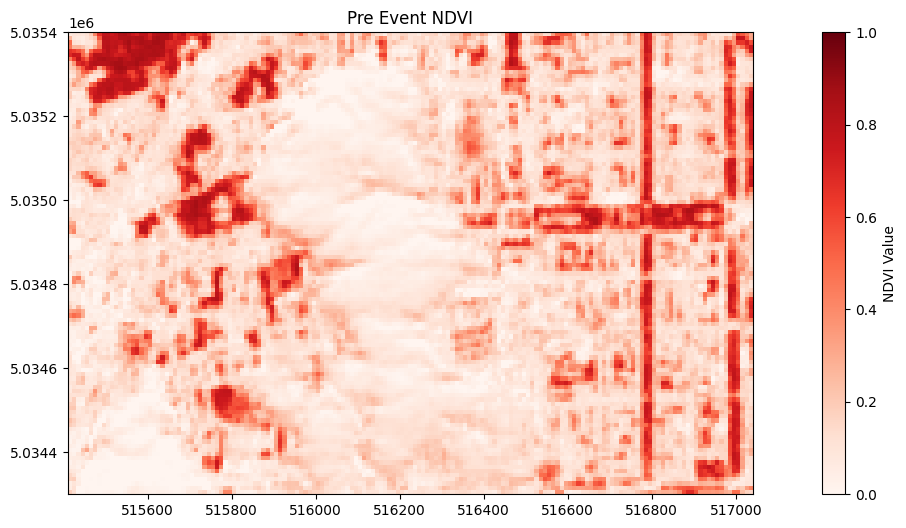

In [24]:
plot_pre_ndvi()


In [25]:
load_post_ndvi(connection, extent, start_date, end_date)

In [32]:
load_pre_nbr(connection, extent, start_date, end_date)

In [30]:
post_nbr(connection, extent, start_date, end_date)

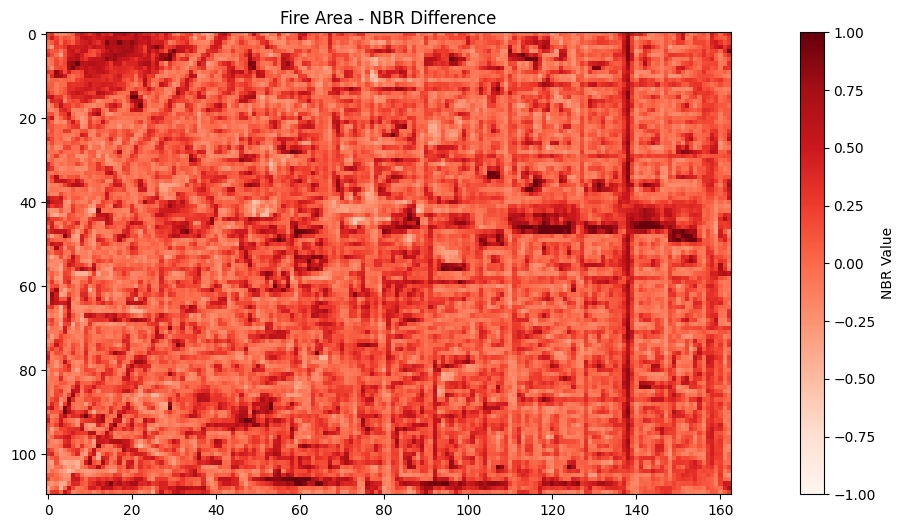

In [33]:
fire_detector_nbr()